# Scaffold analysis of human steroid receptors ligands

## About the data

### Steroid receptors

In humans, we recognize six steroid receptors:
<table>
    <tr><td>ERa</td><td>Estrogen receptor alpha</td></tr>
    <tr><td>ERb</td><td>Estrogen receptor beta</td></tr>
    <tr><td>GR</td><td>Glucocorticoid receptor</td></tr>
    <tr><td>MR</td><td>Mineralocorticoid receptor</td></tr>
    <tr><td>PR</td><td>Progesterone receptor</td></tr>
    <tr><td>AR</td><td>Androgen receptor</td></tr>
</table>

### Biological activity

When some molecule binds to a receptor and causes some effect (either activating it or blocking it) we say it exhibits a **biological activity**.

The biological activity can be quantified in many ways. The most common are dissociation constants (Kd, Ki) or half-effect-concentrations (EC50, IC50). All those four are measured in concentration units (usually nanomols) and are in the same order and thus can be approximately unified into one.

### The source of data

In Chembl database (https://www.ebi.ac.uk/chembl/) there are stored results of experimental measures of activity of many compounds. I have downloaded a .csv file where each row contains (among others) the information about what molecule has what activity on which receptor.

The measured activity is stored in the column *Standard_Value* which is in the concentration units. However we will work with the *pCHEMBL_Value*, which is $-log_{10}$(Standard_Value in mols) and we will use it as the main dependent variable.

### Molecular structure encoding

The 2D structures of molecules are encoded into the linear string representation called **SMILES string**, for example *'CN1CCC[C@H]1c2cccnc2'*. The alternative way is using InCHI encoding. For IDs it's usefull to use the hashed version **InCHI-key**.

For the purpose of data analysis, we need to encode the molecule into a fixed numerical vector. For this purpose we will use binary 1024-bit long **morgan fingerprint**.

### Scaffold

There are many molecules that are very similar, they might differ only in one or few functional groups. We will work with simplified molecular structures called scaffolds. See down for an example. There can be more molecules having the same scaffold and the hypothesis is that they should also exhibit similar activity.

In [1]:
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt

from standardiser import standardise
import molvs

from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles, MolToSmiles, MolToInchi, InchiToInchiKey, PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol, MakeScaffoldGeneric

[10/06/19 23:42:29 standardiser.standardise WARNING] Running under Windows: must disable use of timeout


# Data preparation

I have downloaded the .csv file with activities from the Chembl25 website using the following query:

<code>
(
target_chembl_id:CHEMBL206 OR 
target_chembl_id:CHEMBL242 OR 
target_chembl_id:CHEMBL2034 OR
target_chembl_id:CHEMBL1994 OR 
target_chembl_id:CHEMBL208 OR 
target_chembl_id:CHEMBL1871
) AND (standard_type:IC50 OR standard_type:EC50 OR standard_type:Ki OR standard_type:Kd) AND assay_type:B
    </code>

In [2]:
receptors = 'ERa,ERb,GR,MR,PR,AR'.split(',')
receptors_chembl_ids = 'CHEMBL206,CHEMBL242,CHEMBL2034,CHEMBL1994,CHEMBL208,CHEMBL1871'.split(',')
chembl_id_to_name = {a:b for a,b in zip(receptors_chembl_ids, receptors)}

In [3]:
df = pd.read_csv('primary_data/CHEMBL25-all.csv')
df.rename(lambda x:x.replace(' ','_'), axis='columns', inplace=True)

In [13]:
print('There are %d rows of activities' % len(df))

There are 22420 rows of activities


In [4]:
df.head()

,Molecule,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Comment,Compound_Key,Assay,Assay_Description,BAO_Format,Target,Target_Pref._Name,Target_Organism,Target_Type,Document,Source,Max_Phase,#Ro5_Violations,Molecular_Weight,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,ALogP,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Organism_Tax_ID,BAO_Format_ID,Published_Type,Published_Relation,Published_Value,Published_Units,Canonical_Smiles,Data_Validity_Comment,Document_Journal,Document_Year,SRC_ID,UO_Units,Potential_Duplicate
0,CHEMBL1254420,IC50,=,2.3,nM,8.64,NaN,56,CHEMBL1250864,Binding affinity to glucocorticoid receptor ex...,cell-based format,CHEMBL2034,Glucocorticoid receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1250518,Scientific Literature,0,0.0,422.42,20.45,0.39,3.80,14.86,4.84,NaN,NaN,NaN,NaN,NaN,9606,BAO_0000219,NaN,NaN,NaN,NaN,CC(C)(CC(O)(Cc1cc2ccncc2[nH]1)C(F)(F)F)c3cc(F)...,NaN,J. Med. Chem.,2010.0,1,UO_0000065,False
1,CHEMBL225349,EC50,=,3070.0,nM,5.51,NaN,4b,CHEMBL916265,Activity at human ERalpha expressed in HAECT1 ...,cell-based format,CHEMBL206,Estrogen receptor alpha,Homo sapiens,SINGLE PROTEIN,CHEMBL1149265,Scientific Literature,0,0.0,270.29,20.40,0.38,2.67,7.02,2.84,Homo sapiens,NaN,NaN,HAECT1,NaN,9606,BAO_0000219,NaN,NaN,NaN,NaN,CCn1nc(c2ccc(O)cc2O)c3ccc(O)cc13,NaN,J. Med. Chem.,2004.0,1,UO_0000065,False
2,CHEMBL222522,IC50,=,59.0,nM,7.23,NaN,11h,CHEMBL916819,Activity at human ERalpha expressed in HAECT1 ...,cell-based format,CHEMBL206,Estrogen receptor alpha,Homo sapiens,SINGLE PROTEIN,CHEMBL1149265,Scientific Literature,0,0.0,332.32,21.75,0.41,2.31,19.00,4.92,Homo sapiens,NaN,NaN,HAECT1,NaN,9606,BAO_0000219,NaN,NaN,NaN,NaN,Cc1cc(O)ccc1c2nn(CC=C)c3c(cccc23)C(F)(F)F,NaN,J. Med. Chem.,2004.0,1,UO_0000065,False
3,CHEMBL373743,IC50,=,18.0,nM,7.75,NaN,11f,CHEMBL916819,Activity at human ERalpha expressed in HAECT1 ...,cell-based format,CHEMBL206,Estrogen receptor alpha,Homo sapiens,SINGLE PROTEIN,CHEMBL1149265,Scientific Literature,0,0.0,296.35,26.13,0.48,3.08,20.35,4.66,Homo sapiens,NaN,NaN,HAECT1,NaN,9606,BAO_0000219,NaN,NaN,NaN,NaN,Oc1ccc(cc1)c2nn(C3CCCC3)c4c(F)cccc24,NaN,J. Med. Chem.,2004.0,1,UO_0000065,False
4,CHEMBL221676,IC50,=,196.0,nM,6.71,NaN,8c,CHEMBL916819,Activity at human ERalpha expressed in HAECT1 ...,cell-based format,CHEMBL206,Estrogen receptor alpha,Homo sapiens,SINGLE PROTEIN,CHEMBL1149265,Scientific Literature,0,1.0,368.36,18.21,0.34,1.23,17.63,5.48,Homo sapiens,NaN,NaN,HAECT1,NaN,9606,BAO_0000219,NaN,NaN,NaN,NaN,Oc1ccc(cc1)c2nn(Cc3ccccc3)c4c(cccc24)C(F)(F)F,NaN,J. Med. Chem.,2004.0,1,UO_0000065,False


### Basic filtering

We first plot the histogram of the lengths of smiles strings. Because it shows fat right-tail, we use the log-scale.

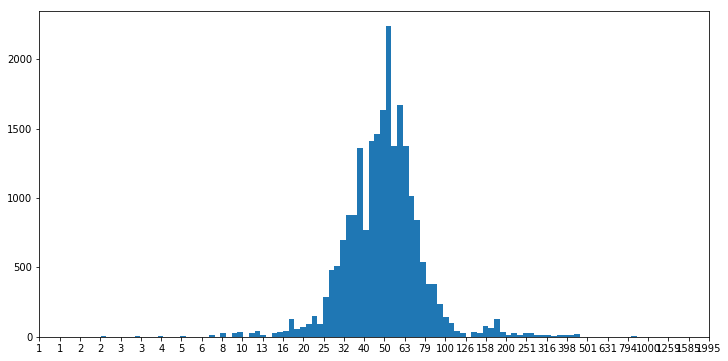

In [5]:
plt.figure(figsize=(12,6))
log_lens = [np.log10(len(x)) for x in df.Canonical_Smiles.dropna()]
plt.hist(log_lens, bins=100);
plt.xticks(np.arange(0,max(log_lens)+0.25,0.1))
a,b = plt.xticks()
# plt.xticks(a)
plt.xticks(a,['%.0f' % x for x in 10**a]);

We filter NaNs and huge molecules with smiles string of length > 200. These are slow to process (the next step) and aren't useful anyways. Therefore we consider them as outliers and discard them.

In [8]:
df_clean = df.query('pChEMBL_Value.notnull() and Canonical_Smiles.notnull() and Canonical_Smiles.str.len() <= 200')
df_clean["receptor_name"] = df_clean.Target.apply(lambda x:chembl_id_to_name[x])

f:\programy\Miniconda3\envs\main\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
print('After cleaning we have %d rows of activities' % len(df_clean))

After cleaning we have 13724 rows of activities


### Standardization of the molecules

The molecular structures from the database can sometimes be invalid or contain strange parts. Also there are more ways how to encode one structure, so we need to normalize them.

I use a combination of two standardization libraries.

In [9]:
df_molecules = df_clean[["Molecule", "Canonical_Smiles"]] \
    .drop_duplicates() \
    .set_index('Molecule') \
    .copy()

In [10]:
# standardise molecules and group activities by the standardised parent molecule
class CustomStandardiser:
    def __init__(self):
        self.standardiser = molvs.Standardizer()
        self.tautomer_canonicalizer = molvs.tautomer.TautomerCanonicalizer()
        self.reionzer = molvs.charge.Reionizer()

    def standardise(self, smiles):
        mol = MolFromSmiles(smiles)
        try:
            standard_parent = standardise.run(mol) # Francis Atkinson
            standard_parent2 = self.standardiser.standardize(standard_parent) # MolVS
            tautomer_parent = self.tautomer_canonicalizer.canonicalize(standard_parent2) # MolVS tautomer
            reionized_parent = self.reionzer.reionize(tautomer_parent) # MolVS reionize
            
            return reionized_parent
        except Exception as e:
            print(e)
            display(mol)
            print('---')
            return None

In [11]:
cs = CustomStandardiser()

In [12]:
print('There are', len(df_molecules), 'molecules')

There are 6955 molecules


We run the standardization, the invalid molecules get printed out with the reason why they are invalid.

Multiple non-salt/solvate components


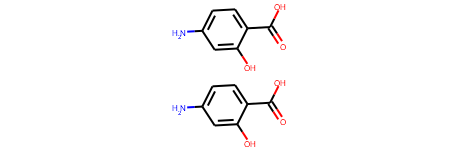

---
No non-salt/solvate components


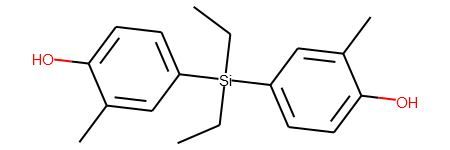

---
No non-salt/solvate components


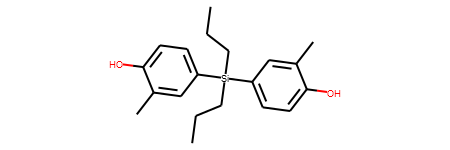

---
No non-salt/solvate components


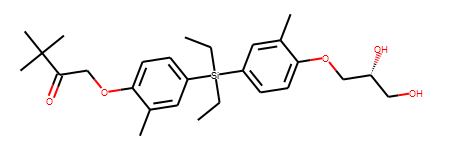

---
Multiple non-salt/solvate components


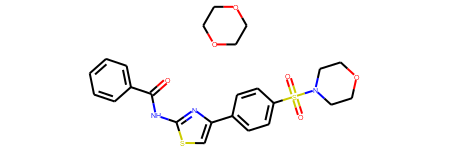

---
No non-salt/solvate components


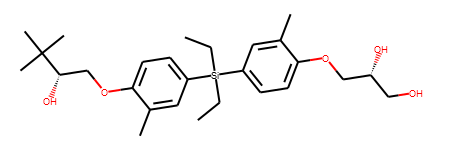

---
No non-salt/solvate components


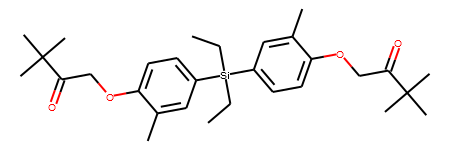

---
No non-salt/solvate components


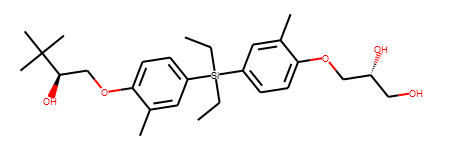

---
No non-salt/solvate components


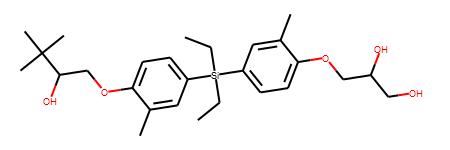

---
No non-salt/solvate components


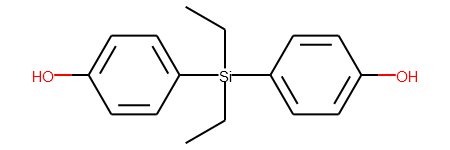

---
No non-salt/solvate components


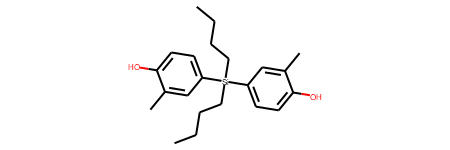

---
No non-salt/solvate components


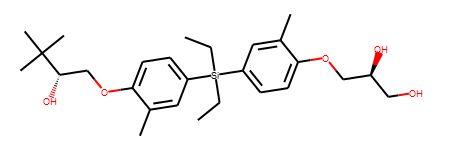

---
No non-salt/solvate components


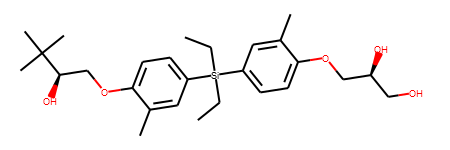

---
No non-salt/solvate components


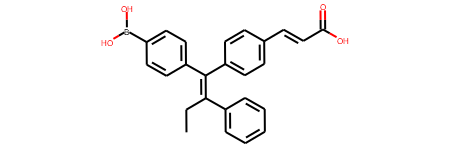

---
No non-salt/solvate components


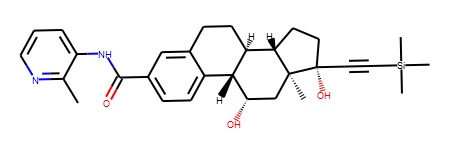

---


In [78]:
std_mols = np.asarray(list(map(cs.standardise, tqdm_notebook(df_molecules.Canonical_Smiles.values))))

In [79]:
np.save('secondary_data/std_mols.npy',std_mols)

In [16]:
std_mols = np.load('secondary_data/std_mols.npy', allow_pickle=True)

Now we encode the structures to smiles, inchi and inchi key.

In [17]:
df_molecules['std_smiles'] = [x if x is None else MolToSmiles(x) for x in std_mols]
df_molecules['std_inchi']  = [x if x is None else MolToInchi(x) for x in std_mols]
df_molecules['std_inchi_key'] = [x if x is None else InchiToInchiKey(x) for x in df_molecules.std_inchi]

In [18]:
df_molecules_std = df_molecules[std_mols != None] \
    .drop_duplicates('std_inchi_key') \
    .set_index('std_inchi_key') \
    .drop('Canonical_Smiles', axis='columns') \
    .copy()

In [19]:
df_molecules.drop(['Canonical_Smiles','std_smiles','std_inchi'], axis='columns', inplace=True) # those columns are redundant now

In [20]:
df_molecules_std.head()

,std_smiles,std_inchi
std_inchi_key,,
NAKVZBYNDIOTLA-UHFFFAOYSA-N,CC(C)(CC(O)(Cc1cc2ccncc2[nH]1)C(F)(F)F)c1cc(F)...,"InChI=1S/C22H22F4N2O2/c1-20(2,17-9-15(23)7-14-..."
FPECYZJXGMTZAF-UHFFFAOYSA-N,CCn1nc(-c2ccc(O)cc2O)c2ccc(O)cc21,InChI=1S/C15H14N2O3/c1-2-17-13-7-9(18)3-5-11(1...
SWJSHDFDYLZVEN-UHFFFAOYSA-N,C=CCn1nc(-c2ccc(O)cc2C)c2cccc(C(F)(F)F)c21,InChI=1S/C18H15F3N2O/c1-3-9-23-17-14(5-4-6-15(...
IYPUUNMLLKLEOH-UHFFFAOYSA-N,Oc1ccc(-c2nn(C3CCCC3)c3c(F)cccc23)cc1,InChI=1S/C18H17FN2O/c19-16-7-3-6-15-17(12-8-10...
DYDWLVOJCJFDBV-UHFFFAOYSA-N,Oc1ccc(-c2nn(Cc3ccccc3)c3c(C(F)(F)F)cccc23)cc1,"InChI=1S/C21H15F3N2O/c22-21(23,24)18-8-4-7-17-..."


## Summarize the activities for each standardised molecule

For each pair of standardised molecule and receptor there can be more rows (experiments) with measured activity.
We summarize the values taking a median.

In [21]:
df_activity = df_clean \
    .join(df_molecules, on='Molecule', how='inner') \
    .join(df_molecules_std, on='std_inchi_key', how='inner') \
    .groupby(['std_inchi_key', 'receptor_name']) \
    .aggregate('median') \
    [['Standard_Value','pChEMBL_Value']] \
    .reset_index('receptor_name') \
    .copy()

In [22]:
df_activity.head()

,receptor_name,Standard_Value,pChEMBL_Value
std_inchi_key,,,
AABLNHSZFIPOBJ-UHFFFAOYSA-N,GR,31.00,7.510
AACVSEPXXNRBIR-UHFFFAOYSA-N,PR,16.40,7.790
AADGIVANXMJZCW-HFPMIOGFSA-N,MR,7025.00,6.075
AAFYPWXCJRYVKV-ILTCGSTDSA-N,GR,0.89,9.050
AAJNWJFLYOFHIB-UHFFFAOYSA-N,GR,17.00,7.770


## Generate fingerprints

For data analysis we need to encode the structure into a fixed numerical vector. 
For that purpose we use a binary hashed morgan fingerprint of length 1024.

In [23]:
std_mols_clean = list(map(MolFromSmiles, df_molecules_std.std_smiles))

In [24]:
df_molecules_std['std_morgan_fp'] = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024).ToBitString() for mol in std_mols_clean]

## Generate scaffolds

A scaffold is a simplified structure, where we (among other simplifications) don't differenciate between atom types and bonds.

In [25]:
scaffolds = [MakeScaffoldGeneric(GetScaffoldForMol(mol)) for mol in std_mols_clean]

Molecule:


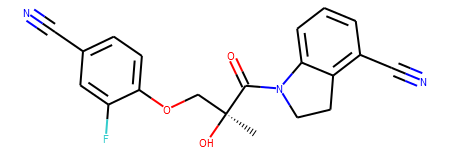

Its scaffold:


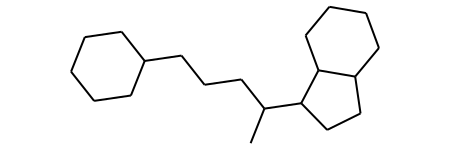

In [26]:
picked_mol = 666
print('Molecule:')
display(std_mols_clean[picked_mol])
print('Its scaffold:')
display(scaffolds[picked_mol])

In [27]:
df_molecules_std['scaffold_smiles'] = [MolToSmiles(mol) for mol in scaffolds]
df_molecules_std['scaffold_inchi'] = [MolToInchi(mol) for mol in scaffolds]
df_molecules_std['scaffold_inchi_key'] = [InchiToInchiKey(mol) for mol in df_molecules_std.scaffold_inchi]

In [28]:
df_molecules_std['scaffold_morgan_fp'] = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024).ToBitString() for mol in scaffolds]

In [33]:
print('There are %d different molecules with %d different scaffolds' % (len(df_molecules_std), len(df_molecules_std.drop_duplicates('scaffold_inchi_key'))))

There are 6876 different molecules with 1491 different scaffolds


## Export the data

In [93]:
df_clean.to_csv('secondary_data/df_clean.csv')
df_molecules_std.to_csv('secondary_data/df_molecules_std.csv')
df_activity.to_csv('secondary_data/df_activity.csv')